# Forecasting 

Sales projection by segment

<font color="red">***still working***</font>

Train a time series forecast model to forecast sales (Sales column) for the segment with the highest sales volume (across the entire
- history (daily frequency)
- Model validation: December 2014 (daily frequency)
- Use MAPE, SMAPE and RMSLE metrics to calculate the result in Dec 2014.



### Import Librarys and DataSet

In [15]:
# Data Analysis Step
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# plot parameters
%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['figure.facecolor'] = '#00000000'

# outliers with mahalanobis
from scipy.spatial import distance

# Machile Learning
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

ModuleNotFoundError: No module named 'fbprophet'

In [3]:
def summary(df):
    """
    Display a summary of a DataFrame.

    This function displays the first few rows of the DataFrame, basic information about the DataFrame's structure,
    and summary statistics including percentiles.

    Parameters:
    df (DataFrame): The pandas DataFrame to be summarized.

    Returns:
    None
    """

    display(f'Rows: {df.shape[0]}; Columns: {df.shape[1]}')
    display(df.head())
    print('-' * 100)
    display(df.info())
    print('-' * 100)
    display(df.describe([0.01, 0.25, 0.50, 0.75, 0.99]))

In [4]:
dataset = pd.read_csv('../output/dataset_time_series_igr.csv', parse_dates=['Order Date', 'Ship Date']) # IGR outleir
df = dataset.copy()

In [9]:
summary(df)

'Rows: 45635; Columns: 16'

,Order ID,Order Date,Ship Date,customer ID,Segment,City,State,Region,Country,Market,Product ID,Category,Product Name,Sales,Quantity,Profit
0,ID-2011-24160,2011-12-29,2012-01-01,20170,Consumer,Gold Coast,Queensland,Oceania,Australia,APAC,TEC-PH-10002601,Technology,"Motorola Smart Phone, Cordless",578.502,1,-38.5680
1,ID-2011-24160,2011-12-29,2012-01-01,20170,Consumer,Gold Coast,Queensland,Oceania,Australia,APAC,FUR-BO-10002308,Furniture,"Safco Floating Shelf Set, Metal",353.160,2,39.2400
2,CA-2011-104738,2011-12-30,2012-01-01,20620,Corporate,Laredo,Texas,Central,United States,US,TEC-PH-10002468,Technology,"Plantronics CS 50-USB - headset - Convertible,...",217.584,2,19.0386
3,EG-2011-590,2011-12-28,2012-01-01,5370,Consumer,Sohag,Suhaj,Africa,Egypt,Africa,OFF-SME-10003752,Office Supplies,"Smead File Cart, Single Width",513.720,4,5.0400
4,CA-2011-104738,2011-12-30,2012-01-01,20620,Corporate,Laredo,Texas,Central,United States,US,TEC-PH-10000576,Technology,AT&T 1080 Corded phone,328.776,3,28.7679


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45635 entries, 0 to 45634
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order ID      45635 non-null  object        
 1   Order Date    45635 non-null  datetime64[ns]
 2   Ship Date     45635 non-null  datetime64[ns]
 3   customer ID   45635 non-null  int64         
 4   Segment       45635 non-null  object        
 5   City          45635 non-null  object        
 6   State         45635 non-null  object        
 7   Region        45635 non-null  object        
 8   Country       45635 non-null  object        
 9   Market        45635 non-null  object        
 10  Product ID    45635 non-null  object        
 11  Category      45635 non-null  object        
 12  Product Name  45635 non-null  object        
 13  Sales         45635 non-null  float

None

----------------------------------------------------------------------------------------------------


,Order Date,Ship Date,customer ID,Sales,Quantity,Profit
count,45635,45635,45635.00000,45635.000000,45635.000000,45635.000000
mean,2013-05-12 13:16:28.372959232,2013-05-16 12:38:19.393009664,13928.78076,121.659859,3.263789,10.191308
min,2011-01-01 00:00:00,2011-01-03 00:00:00,15.00000,0.444000,1.000000,-1924.542000
1%,2011-02-07 00:00:00,2011-02-10 00:00:00,570.00000,3.488000,1.000000,-225.106860
25%,2012-06-20 00:00:00,2012-06-24 00:00:00,10932.50000,27.180000,2.000000,-0.013200
50%,2013-07-10 00:00:00,2013-07-14 00:00:00,14530.00000,67.080000,3.000000,7.703100
75%,2014-05-22 00:00:00,2014-05-26 00:00:00,18220.00000,168.600000,4.000000,26.661600
99%,2014-12-24 00:00:00,2014-12-29 00:00:00,21775.00000,542.340000,10.000000,179.359200
max,2014-12-31 00:00:00,2015-01-07 00:00:00,21925.00000,581.400000,14.000000,284.220000
std,NaN,NaN,5354.85545,131.533247,2.155229,64.842801


## Data Frame Pre-processing

In [13]:
# create a df
df_ml = df.copy()
df_ml.head()

,Order ID,Order Date,Ship Date,customer ID,Segment,City,State,Region,Country,Market,Product ID,Category,Product Name,Sales,Quantity,Profit
0,ID-2011-24160,2011-12-29,2012-01-01,20170,Consumer,Gold Coast,Queensland,Oceania,Australia,APAC,TEC-PH-10002601,Technology,"Motorola Smart Phone, Cordless",578.502,1,-38.5680
1,ID-2011-24160,2011-12-29,2012-01-01,20170,Consumer,Gold Coast,Queensland,Oceania,Australia,APAC,FUR-BO-10002308,Furniture,"Safco Floating Shelf Set, Metal",353.160,2,39.2400
2,CA-2011-104738,2011-12-30,2012-01-01,20620,Corporate,Laredo,Texas,Central,United States,US,TEC-PH-10002468,Technology,"Plantronics CS 50-USB - headset - Convertible,...",217.584,2,19.0386
3,EG-2011-590,2011-12-28,2012-01-01,5370,Consumer,Sohag,Suhaj,Africa,Egypt,Africa,OFF-SME-10003752,Office Supplies,"Smead File Cart, Single Width",513.720,4,5.0400
4,CA-2011-104738,2011-12-30,2012-01-01,20620,Corporate,Laredo,Texas,Central,United States,US,TEC-PH-10000576,Technology,AT&T 1080 Corded phone,328.776,3,28.7679


In [14]:
#  segment with the highest sales
highest_sales_segment = df_ml.groupby('Segment')['Sales'].sum().idxmax()
df_ml_segment = df_ml[df_ml['Segment'] == highest_sales_segment]

df_ml_segment = df_ml_segment.sort_values(by='Segment')

df_ml_segment.head()

,Order ID,Order Date,Ship Date,customer ID,Segment,City,State,Region,Country,Market,Product ID,Category,Product Name,Sales,Quantity,Profit
0,ID-2011-24160,2011-12-29,2012-01-01,20170,Consumer,Gold Coast,Queensland,Oceania,Australia,APAC,TEC-PH-10002601,Technology,"Motorola Smart Phone, Cordless",578.502,1,-38.568
30354,IN-2014-82652,2014-07-16,2014-07-21,11140,Consumer,Wollongong,New South Wales,Oceania,Australia,APAC,OFF-SU-10001488,Office Supplies,"Stiletto Scissors, Steel",23.010,1,0.450
30353,IN-2014-82652,2014-07-16,2014-07-21,11140,Consumer,Wollongong,New South Wales,Oceania,Australia,APAC,OFF-BI-10004562,Office Supplies,"Acco Binder, Clear",29.220,2,6.720
30351,IN-2014-82652,2014-07-16,2014-07-21,11140,Consumer,Wollongong,New South Wales,Oceania,Australia,APAC,OFF-LA-10002086,Office Supplies,"Hon Shipping Labels, 5000 Label Set",23.520,2,4.680
30345,CG-2014-870,2014-07-19,2014-07-21,705,Consumer,Kinshasa,Kinshasa,Africa,Democratic Republic of the Congo,Africa,OFF-BIC-10001211,Office Supplies,"BIC Highlighters, Water Color",22.110,1,3.960


In [8]:
# reset index for resamle('D')
df_ml_segment.set_index('Order Date', inplace=True)

df_ml_segment.head()

,Order ID,Ship Date,customer ID,Segment,City,State,Region,Country,Market,Product ID,Category,Product Name,Sales,Quantity,Profit
Order Date,,,,,,,,,,,,,,,
2011-12-29,ID-2011-24160,2012-01-01,20170,Consumer,Gold Coast,Queensland,Oceania,Australia,APAC,TEC-PH-10002601,Technology,"Motorola Smart Phone, Cordless",578.502,1,-38.568
2014-07-16,IN-2014-82652,2014-07-21,11140,Consumer,Wollongong,New South Wales,Oceania,Australia,APAC,OFF-SU-10001488,Office Supplies,"Stiletto Scissors, Steel",23.010,1,0.450
2014-07-16,IN-2014-82652,2014-07-21,11140,Consumer,Wollongong,New South Wales,Oceania,Australia,APAC,OFF-BI-10004562,Office Supplies,"Acco Binder, Clear",29.220,2,6.720
2014-07-16,IN-2014-82652,2014-07-21,11140,Consumer,Wollongong,New South Wales,Oceania,Australia,APAC,OFF-LA-10002086,Office Supplies,"Hon Shipping Labels, 5000 Label Set",23.520,2,4.680
2014-07-19,CG-2014-870,2014-07-21,705,Consumer,Kinshasa,Kinshasa,Africa,Democratic Republic of the Congo,Africa,OFF-BIC-10001211,Office Supplies,"BIC Highlighters, Water Color",22.110,1,3.960


In [303]:
# resample on daily frequency and calculate daily sales
daily_sales = df_ml_segment['Sales'].resample('D').sum()
daily_sales_df = daily_sales.reset_index()  # Reset the index to include the date as a column
daily_sales_df.columns = ['Date', 'Sales'] 
daily_sales_df.head()

,Date,Sales
0,2011-01-01,763.6980
1,2011-01-02,314.2200
2,2011-01-03,1465.6262
3,2011-01-04,353.9280
4,2011-01-05,48.7800


In [308]:
daily_sales_df.set_index('Date', inplace=True)
daily_sales_df.head()

,Sales
Date,
2011-01-01,763.6980
2011-01-02,314.2200
2011-01-03,1465.6262
2011-01-04,353.9280
2011-01-05,48.7800


In [311]:
train_data.shape, test_data.shape

((1430, 1), (31, 1))


## Forecasting with PROPHET by Facebook

- Official web site [FB Prophet](https://facebook.github.io/prophet/)
- [Paper Prophet](https://peerj.com/preprints/3190/)
- business times series
- Takes 3 factors into consideration
     - y = trend + seasonality + injuries
- identification of special events (changepoints)
- specification of holidays
- suggested baselines: last value and sample average
- preferred metric: MAPE (mean absolute percentage error)
- requirements:
     - plotly and pip install holidays==0.9.12
- the minimum you need for the dataset is the Date column and the column you want to predict.

In [ ]:
print(f'Prophet {fbprophet.__version__}')

In [10]:
df.head()

,Order ID,Order Date,Ship Date,customer ID,Segment,City,State,Region,Country,Market,Product ID,Category,Product Name,Sales,Quantity,Profit
0,ID-2011-24160,2011-12-29,2012-01-01,20170,Consumer,Gold Coast,Queensland,Oceania,Australia,APAC,TEC-PH-10002601,Technology,"Motorola Smart Phone, Cordless",578.502,1,-38.5680
1,ID-2011-24160,2011-12-29,2012-01-01,20170,Consumer,Gold Coast,Queensland,Oceania,Australia,APAC,FUR-BO-10002308,Furniture,"Safco Floating Shelf Set, Metal",353.160,2,39.2400
2,CA-2011-104738,2011-12-30,2012-01-01,20620,Corporate,Laredo,Texas,Central,United States,US,TEC-PH-10002468,Technology,"Plantronics CS 50-USB - headset - Convertible,...",217.584,2,19.0386
3,EG-2011-590,2011-12-28,2012-01-01,5370,Consumer,Sohag,Suhaj,Africa,Egypt,Africa,OFF-SME-10003752,Office Supplies,"Smead File Cart, Single Width",513.720,4,5.0400
4,CA-2011-104738,2011-12-30,2012-01-01,20620,Corporate,Laredo,Texas,Central,United States,US,TEC-PH-10000576,Technology,AT&T 1080 Corded phone,328.776,3,28.7679


**prophet needs the data column to be named 'ds' to recognize and the column that will predict is named 'y'**

In [12]:
df_prophet = df[['Order Date', 'Sales']]
df_prophet.columns = ['ds', 'y']
df_prophet.head()

,ds,y
0,2011-12-29,578.502
1,2011-12-29,353.160
2,2011-12-30,217.584
3,2011-12-28,513.720
4,2011-12-30,328.776


#### Training and Testing data for Prophet forecasting

In [ ]:
# as required the testing data for December of 2014, train for the rest of 2014
train_data = daily_sales_df[daily_sales_df.index < '2014-12-01']
test_data = daily_sales_df[daily_sales_df.index >= '2014-12-01']

## XGBoost Model

In [336]:
X_train = train_data.values[:-1].reshape(-1, 1)  # Use all data except the last data point for training
y_train = train_data.values[1:]  # Predict the next day's sales
X_train_data.shape, y_train_data.shape

((1429, 1), (1429, 1))

In [337]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=1000)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

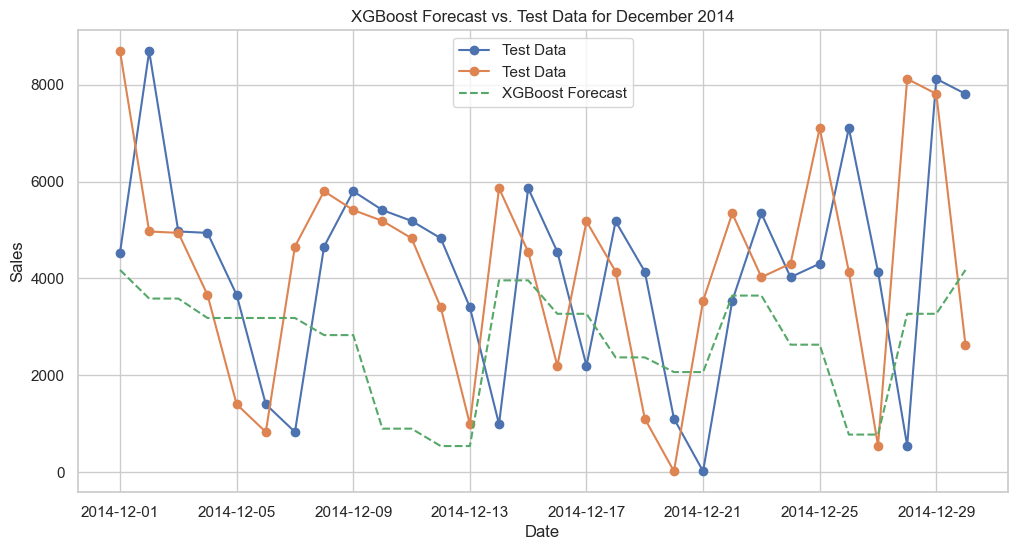

In [343]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Test Data', marker='o')
plt.plot(test_data.index, xgb_forecast, label='XGBoost Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('XGBoost Forecast vs. Test Data for December 2014')
plt.legend()
plt.grid(True)
plt.show()

In [339]:
# Forecast for December 2014
X_valid = test_data.values[:-1].reshape(-1, 1)  # Use all data except the last data point for validation
xgb_forecast = xgb_model.predict(X_valid)

In [341]:
# Calculate the metrics (MAE, MSE, RMSLE)
xgb_forecast = xgb_forecast[:len(test_data)]

mae = mean_absolute_error(test_data[1:], xgb_forecast)
mse = mean_squared_error(test_data[1:], xgb_forecast)
rmsle = np.sqrt(mean_squared_log_error(test_data[1:], xgb_forecast))

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSLE: {rmsle:.4f}")

ValueError: Found input variables with inconsistent numbers of samples: [29, 30]

In [ ]:
# Actual sales data for December 2014
actual_sales_december_2014 = df_daily['2014-12-01':'2014-12-31']

# Calculate MAPE, SMAPE, and RMSLE
mape = mean_absolute_error(actual_sales_december_2014, forecasted_sales) / np.mean(actual_sales_december_2014) * 100
smape = 100 * np.mean(np.abs(forecasted_sales - actual_sales_december_2014) / (np.abs(forecasted_sales) + np.abs(actual_sales_december_2014)))
rmsle = np.sqrt(mean_squared_log_error(actual_sales_december_2014, forecasted_sales))

# Print the results
print("MAPE:", mape)
print("SMAPE:", smape)
print("RMSLE:", rmsle)

#### Forecasting with XGBoost

## Bibliography

- S. D. Science, "Previsão de Séries Temporais | Tutorial sobre Prophet", Youtube, Jul 2021. [Online]. Available: <https://www.youtube.com/watch?v=CW1PZwNG-wQ>. [Accessed: November 08, 2023]
- M. Filho, "Como Criar Modelos de Time Series Com Prophet", Youtube, Fev 2020. [Online]. Available: <https://www.youtube.com/watch?v=4kWROiUYHBc>. [Accessed: November 08, 2023]



 









 